In [ ]:
# Cell 1: Install Dependencies

!pip install -q diffusers transformers accelerate xformers torchvision
!pip install -q matplotlib numpy scikit-image

print("Dependencies installed successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90

In [ ]:
# Install required packages
!pip install gdown

import gdown
import zipfile
import os

# Replace with your Google Drive file ID
file_id = '1oSuEOE3DynxTh1XRTmWb1Pybg4hSpVAG'
url = f'https://drive.google.com/uc?id={file_id}'

# Download the zip file
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

# Create directory for extracted files
os.makedirs('dataset', exist_ok=True)

# Unzip the file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('dataset')

print("Download and extraction complete.")

In [ ]:
# Cell 2: Dataset Loading

import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class AnimeJSONDataset(Dataset):
    def __init__(self, json_path, root_dir, size=512):
        self.root_dir = root_dir
        self.size = size

        # --- FIX: Load JSONL line by line ---
        self.data = []
        with open(json_path, 'r') as f:
            for line in f:
                # Skip empty lines to prevent errors
                if line.strip():
                    self.data.append(json.loads(line))

        print(f"Loaded {len(self.data)} items from {json_path}")

        # Preprocessing: Normalize Target to [-1, 1], Sketch to [0, 1]
        self.image_transforms = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        self.condition_transforms = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Construct full paths
        target_path = os.path.join(self.root_dir, item['image'])
        sketch_path = os.path.join(self.root_dir, item['conditioning_image'])
        prompt = item['text']

        # Load Images
        try:
            target = Image.open(target_path).convert("RGB")
            sketch = Image.open(sketch_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {target_path} or {sketch_path}: {e}")
            # If an image fails, grab the next one to avoid crashing
            return self.__getitem__((idx + 1) % len(self))

        # Apply Transforms
        pixel_values = self.image_transforms(target)
        conditioning_pixel_values = self.condition_transforms(sketch)

        return {
            "pixel_values": pixel_values,
            "conditioning_pixel_values": conditioning_pixel_values,
            "prompt": prompt
        }

In [ ]:
# --- CONFIGURATION ---
ROOT_DIR = "/content/dataset"
JSON_FILE = os.path.join(ROOT_DIR, "train.jsonl")

train_dataset = AnimeJSONDataset(JSON_FILE, ROOT_DIR)
sample = train_dataset[0]
print(f"Sample Prompt: {sample['prompt']}")
print(f"Dataset Size: {len(train_dataset)}")

Loaded 1221 items from /content/dataset/train.jsonl
Sample Prompt: a man with dark hair and brown eyes
Dataset Size: 1221


In [ ]:
# Model Initialization
from diffusers import ControlNetModel, AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer

# 1. Configuration
TOKENIZER_ID = "runwayml/stable-diffusion-v1-5"
MODEL_ID = "stablediffusionapi/anything-v3"

print("Loading models")

try:
    # 2. Load Tokenizer & Text Encoder
    tokenizer = CLIPTokenizer.from_pretrained(TOKENIZER_ID, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(TOKENIZER_ID, subfolder="text_encoder")

    # 3. Load VAE & UNet
    vae = AutoencoderKL.from_pretrained(MODEL_ID, subfolder="vae")
    unet = UNet2DConditionModel.from_pretrained(MODEL_ID, subfolder="unet")

    # 4. Create ControlNet
    controlnet = ControlNetModel.from_unet(unet)

    # 5. Freeze Base Model
    vae.requires_grad_(False)
    unet.requires_grad_(False)
    text_encoder.requires_grad_(False)

    # 6. Set to Train Mode
    controlnet.train()
    controlnet.enable_gradient_checkpointing()

    print("Success! Anime model loaded")

except Exception as e:
    print(f"Error loading model: {e}")

In [ ]:
import os
import shutil
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from diffusers import DDPMScheduler, StableDiffusionControlNetPipeline
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from PIL import Image

In [ ]:
# --- CONFIGURATION ---

# Paths
ROOT_DIR_1 = "/content/drive/MyDrive/ControlNet_V1"
OUTPUT_DIR = os.path.join(ROOT_DIR_1, "checkpoints")
FINAL_DRIVE_DIR = os.path.join(ROOT_DIR_1, "final_model")
LOCAL_FINAL_DIR = "/content/final_model"
VAL_OUTPUT_DIR = os.path.join(ROOT_DIR_1, "validation_outputs")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(VAL_OUTPUT_DIR, exist_ok=True)
os.makedirs(FINAL_DRIVE_DIR, exist_ok=True)

# Hyperparameters
LEARNING_RATE = 2e-5
BATCH_SIZE = 24
NUM_EPOCHS = 100

In [ ]:
# --- 2. SETUP ACCELERATOR ---
accelerator = Accelerator(mixed_precision="bf16")
device = accelerator.device
weight_dtype = torch.bfloat16

In [ ]:
# --- 3. PREPARE MODELS & DATA ---
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)
unet.to(device, dtype=weight_dtype)
controlnet.to(device, dtype=torch.float32)

train_dataset = AnimeJSONDataset(JSON_FILE, ROOT_DIR)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

optimizer = AdamW(controlnet.parameters(), lr=LEARNING_RATE)
noise_scheduler = DDPMScheduler.from_pretrained(MODEL_ID, subfolder="scheduler")

controlnet, optimizer, train_dataloader = accelerator.prepare(controlnet, optimizer, train_dataloader)

In [ ]:
# --- TRAINING LOOP ---
global_step = 0
print(f"⚡ Starting Training... (Saving at end of every Epoch)")

for epoch in range(NUM_EPOCHS):
    controlnet.train()
    progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch+1}")
    epoch_loss_total = 0

    for step, batch in enumerate(train_dataloader):
        # Forward Pass
        with torch.no_grad():
            pixel_values = batch["pixel_values"].to(device, dtype=weight_dtype)
            latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor
            inputs = tokenizer(batch["prompt"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
            encoder_hidden_states = text_encoder(inputs.input_ids.to(device))[0]

        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        with torch.autocast("cuda", dtype=torch.bfloat16):
            down, mid = controlnet(
                noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states,
                controlnet_cond=batch["conditioning_pixel_values"].to(device, dtype=weight_dtype), return_dict=False
            )
            pred = unet(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states,
                        down_block_additional_residuals=down, mid_block_additional_residual=mid).sample
            loss = F.mse_loss(pred.float(), noise.float())

        accelerator.backward(loss)
        if accelerator.sync_gradients: accelerator.clip_grad_norm_(controlnet.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        epoch_loss_total += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
        global_step += 1

    # --- END OF EPOCH ACTIONS ---
    avg_loss = epoch_loss_total / len(train_dataloader)
    print(f"\n Epoch {epoch+1} Loss: {avg_loss:.5f}")

    # SAVE CHECKPOINT
    save_path = os.path.join(OUTPUT_DIR, f"checkpoint-epoch-{epoch+1}")
    accelerator.unwrap_model(controlnet).save_pretrained(save_path)
    print(f" Saved Checkpoint: {save_path}")

# --- SAVE ---
print("\n Training Finished! Saving Final Model...")
unwrapped_model = accelerator.unwrap_model(controlnet)

# Save to Drive
unwrapped_model.save_pretrained(FINAL_DRIVE_DIR)
print(f" Final Model saved to Google Drive: {FINAL_DRIVE_DIR}")

# Save to Local Colab Disk
unwrapped_model.save_pretrained(LOCAL_FINAL_DIR)
print(f" Final Model saved to Local Disk: {LOCAL_FINAL_DIR}")

Loaded 1221 items from /content/dataset/train.jsonl
⚡ Starting Training... (Saving at end of every Epoch)


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 1 Loss: 0.09940
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-1


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 2 Loss: 0.10631
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-2


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 3 Loss: 0.09963
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-3


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 4 Loss: 0.10470
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-4


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 5 Loss: 0.10483
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-5


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 6 Loss: 0.10499
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-6


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 7 Loss: 0.10292
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-7


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 8 Loss: 0.10074
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-8


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 9 Loss: 0.10560
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-9


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 10 Loss: 0.10204
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-10


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 11 Loss: 0.10335
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-11


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 12 Loss: 0.09763
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-12


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 13 Loss: 0.10584
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-13


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 14 Loss: 0.09977
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-14


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 15 Loss: 0.09602
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-15


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 16 Loss: 0.10208
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-16


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 17 Loss: 0.09931
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-17


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 18 Loss: 0.10540
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-18


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 19 Loss: 0.09910
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-19


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 20 Loss: 0.09655
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-20


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 21 Loss: 0.10541
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-21


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 22 Loss: 0.10031
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-22


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 23 Loss: 0.09715
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-23


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 24 Loss: 0.10027
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-24


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 25 Loss: 0.09843
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-25


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 26 Loss: 0.10270
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-26


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 27 Loss: 0.10264
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-27


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 28 Loss: 0.10486
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-28


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 29 Loss: 0.10005
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-29


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 30 Loss: 0.09776
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-30


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 31 Loss: 0.10380
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-31


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 32 Loss: 0.09550
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-32


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 33 Loss: 0.09910
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-33


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 34 Loss: 0.10841
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-34


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 35 Loss: 0.09736
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-35


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 36 Loss: 0.09945
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-36


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 37 Loss: 0.09015
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-37


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 38 Loss: 0.08978
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-38


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 39 Loss: 0.09314
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-39


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 40 Loss: 0.08296
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-40


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 41 Loss: 0.08772
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-41


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 42 Loss: 0.08859
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-42


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 43 Loss: 0.09212
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-43


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 44 Loss: 0.08015
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-44


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 45 Loss: 0.09128
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-45


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 46 Loss: 0.08100
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-46


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 47 Loss: 0.08907
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-47


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 48 Loss: 0.08558
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-48


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 49 Loss: 0.09239
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-49


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 50 Loss: 0.08639
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-50


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 51 Loss: 0.08491
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-51


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 52 Loss: 0.08433
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-52


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 53 Loss: 0.08024
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-53


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 54 Loss: 0.08610
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-54


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 55 Loss: 0.07619
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-55


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 56 Loss: 0.08529
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-56


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 57 Loss: 0.08437
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-57


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 58 Loss: 0.08439
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-58


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 59 Loss: 0.08140
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-59


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 60 Loss: 0.08472
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-60


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 61 Loss: 0.07718
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-61


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 62 Loss: 0.08066
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-62


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 63 Loss: 0.07582
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-63


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 64 Loss: 0.07684
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-64


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 65 Loss: 0.09171
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-65


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 66 Loss: 0.08214
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-66


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 67 Loss: 0.08085
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-67


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 68 Loss: 0.08116
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-68


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 69 Loss: 0.08157
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-69


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 70 Loss: 0.08145
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-70


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 71 Loss: 0.08193
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-71


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 72 Loss: 0.08451
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-72


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 73 Loss: 0.07924
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-73


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 74 Loss: 0.08148
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-74


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 75 Loss: 0.08146
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-75


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 76 Loss: 0.08540
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-76


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 77 Loss: 0.07393
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-77


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 78 Loss: 0.08258
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-78


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 79 Loss: 0.08220
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-79


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 80 Loss: 0.08135
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-80


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 81 Loss: 0.08060
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-81


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 82 Loss: 0.07963
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-82


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 83 Loss: 0.07775
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-83


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 84 Loss: 0.07921
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-84


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 85 Loss: 0.08155
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-85


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 86 Loss: 0.07994
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-86


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 87 Loss: 0.07876
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-87


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 88 Loss: 0.07461
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-88


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 89 Loss: 0.07750
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-89


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 90 Loss: 0.08028
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-90


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 91 Loss: 0.07220
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-91


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 92 Loss: 0.08224
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-92


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 93 Loss: 0.07214
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-93


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 94 Loss: 0.07434
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-94


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 95 Loss: 0.08132
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-95


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 96 Loss: 0.08002
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-96


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 97 Loss: 0.07746
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-97


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 98 Loss: 0.07274
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-98


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 99 Loss: 0.08147
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-99


  0%|          | 0/51 [00:00<?, ?it/s]


 Epoch 100 Loss: 0.08018
 Saved Checkpoint: /content/drive/MyDrive/ControlNet_V1/checkpoints/checkpoint-epoch-100

 Training Finished! Saving Final Model...
 Final Model saved to Google Drive: /content/drive/MyDrive/ControlNet_V1/final_model
 Final Model saved to Local Disk: /content/final_model


✅ Graph saved to: /content/dataset/training_loss_curve.png


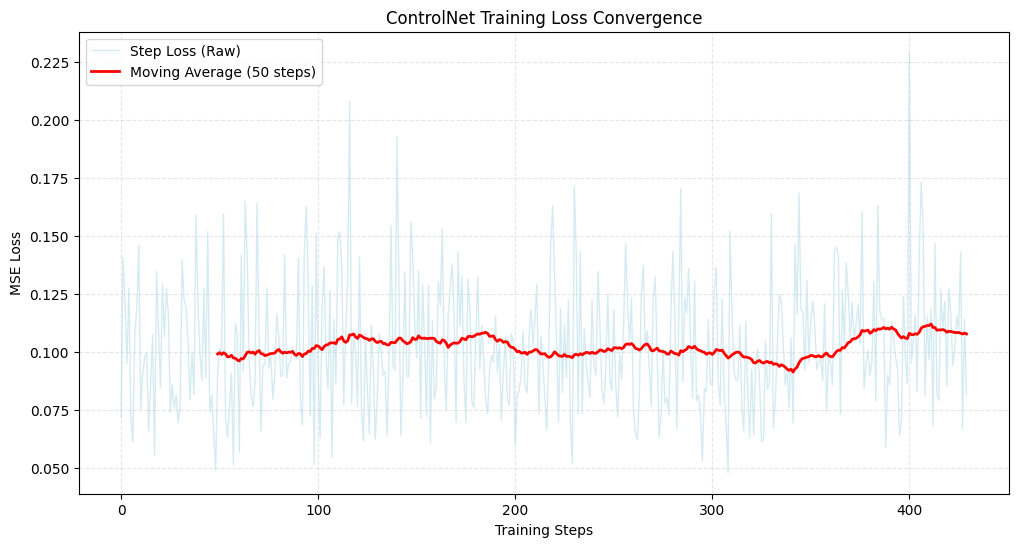

In [ ]:
# Plot Training Loss Function

import matplotlib.pyplot as plt
import numpy as np
import os

def plot_losses(loss_history, output_dir=None, smooth_window=50):
    if not loss_history or len(loss_history) == 0:
        print(" No loss history found to plot.")
        return

    plt.figure(figsize=(12, 6))

    # 1. Plot Raw Step Loss (Light Blue)
    plt.plot(loss_history, label="Step Loss (Raw)", color='lightblue', alpha=0.5, linewidth=1)

    # 2. Calculate and Plot Moving Average (Red)
    # This helps visualize the trend amidst the noise
    if len(loss_history) >= smooth_window:
        moving_avg = np.convolve(loss_history, np.ones(smooth_window)/smooth_window, mode='valid')
        plt.plot(range(smooth_window-1, len(loss_history)), moving_avg,
                 label=f"Moving Average ({smooth_window} steps)", color='red', linewidth=2)

    # 3. Formatting
    plt.xlabel("Training Steps")
    plt.ylabel("MSE Loss")
    plt.title("ControlNet Training Loss Convergence")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)

    # 4. Save to Drive
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        save_path = os.path.join(output_dir, "training_loss_curve.png")
        plt.savefig(save_path, dpi=300)
        print(f"Graph saved to: {save_path}")

    plt.show()

if 'loss_history' in globals():
    plot_losses(loss_history, output_dir=ROOT_DIR)
else:
    print(" 'loss_history' variable not found. Did you run the training cell?")

🎲 Selected Random Sketch: /content/dataset/conditioning/condition_0575.png
⏳ Loading Base Models in Float16...
   Generaing with Epoch 40...


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

   Generaing with Epoch 50...


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

   Generaing with Epoch 70...


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

   Generaing with Epoch 97...


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

   Generaing with Epoch 100...


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

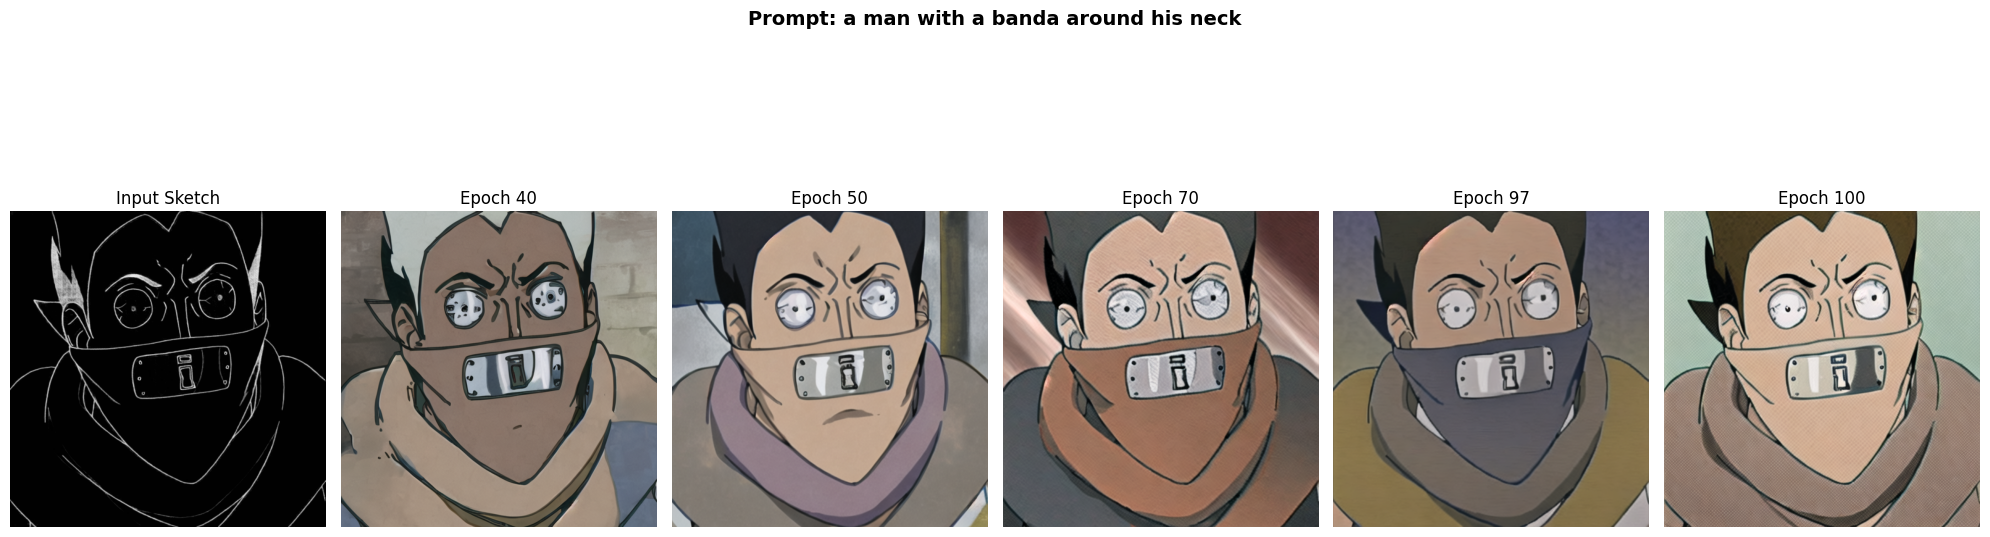

In [ ]:
# Comparison (With Prompt Display)
import torch
import matplotlib.pyplot as plt
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
import os
import json
import random
import textwrap

# 1. SETUP
device = "cuda"
base_model = "stablediffusionapi/anything-v3"
epoch_list = [40,50, 70, 97, 100]

# 2. SELECT RANDOM SKETCH
try:
    with open(JSON_FILE, 'r') as f:
        # Robustly read JSONL
        lines = [line for line in f if line.strip()]
        random_line = random.choice(lines)
        item = json.loads(random_line)

        sketch_path = os.path.join(ROOT_DIR, item['conditioning_image'])
        original_prompt = item['text']

        print(f"Selected Random Sketch: {sketch_path}")
        sketch = Image.open(sketch_path).convert("RGB").resize((512, 512))

except Exception as e:
    print(f"Error loading JSONL: {e}")
    sketch = None

# 3. RUN COMPARISON
if sketch:
    print("⏳ Loading Base Models in Float16...")
    tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="text_encoder", torch_dtype=torch.float16).to(device)
    vae = AutoencoderKL.from_pretrained(base_model, subfolder="vae", torch_dtype=torch.float16).to(device)
    unet = UNet2DConditionModel.from_pretrained(base_model, subfolder="unet", torch_dtype=torch.float16).to(device)

    # Setup Plot
    fig, axs = plt.subplots(1, len(epoch_list) + 1, figsize=(20, 7))

    # Show Prompt at the top
    wrapped_prompt = "\n".join(textwrap.wrap(f"Prompt: {original_prompt}", width=80))
    plt.suptitle(wrapped_prompt, fontsize=14, fontweight='bold', y=0.95)

    axs[0].imshow(sketch)
    axs[0].set_title("Input Sketch")
    axs[0].axis("off")

    for i, epoch in enumerate(epoch_list):
        checkpoint_path = os.path.join(OUTPUT_DIR, f"checkpoint-epoch-{epoch}")

        if os.path.exists(checkpoint_path):
            print(f"   Generaing with Epoch {epoch}...")
            controlnet = ControlNetModel.from_pretrained(checkpoint_path, torch_dtype=torch.float16).to(device)

            pipe = StableDiffusionControlNetPipeline.from_pretrained(
                base_model, controlnet=controlnet, vae=vae, text_encoder=text_encoder,
                tokenizer=tokenizer, unet=unet, safety_checker=None, torch_dtype=torch.float16
            ).to(device)
            pipe.set_progress_bar_config(disable=True)

            # Generate
            image = pipe(original_prompt, image=sketch, num_inference_steps=30).images[0]

            axs[i+1].imshow(image)
            axs[i+1].set_title(f"Epoch {epoch}")
            axs[i+1].axis("off")

            del controlnet, pipe
            torch.cuda.empty_cache()
        else:
            axs[i+1].text(0.5, 0.5, f"Epoch {epoch}\nNot Found", ha='center')
            axs[i+1].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85) # Make room for the prompt title
    plt.show()
else:
    print("No sketch found.")